# Map clean fsLR-32k time series to parcellation

In [1]:
import nibabel as nib
import pandas as pd
import numpy as np

In [2]:
# Set the path to your clean fMRI fsLR-32k
out='/data_/mica3/BIDS_PNI/derivatives'
file=f'{out}/micapipe_v0.2.0/sub-PNC002/ses-01/func/desc-me_task-rest_bold/surf/sub-PNC002_ses-01_surf-fsLR-32k_desc-timeseries_clean.shape.gii'

# Load func time series fsLR-32k
timeseries=nib.load(file).darrays[0].data


In [3]:
# The time series array MUST be the { 'Number of time points' x 'number of vertices (64984)' ]
timeseries.shape


(275, 64984)

In [4]:
# Read the parcellation you want to use from micapipe repository
parc_str='glasser-360'
parc_pd = pd.read_csv(f'https://raw.githubusercontent.com/MICA-MNI/micapipe/master/parcellations/{parc_str}_conte69.csv', header=None)
parc =parc_pd.iloc[:, 0].values 


The following parcellations are available in micapipe:
- aparc-a2009s
- aparc
- economo
- glasser-360
- schaefer-1000
- schaefer-100
- schaefer-200
- schaefer-300
- schaefer-400
- schaefer-500
- schaefer-600
- schaefer-700
- schaefer-800
- schaefer-900
- vosdewael-100
- vosdewael-200
- vosdewael-300
- vosdewael-400

## Parcellated cortical timeseries

In [5]:
# Get the unique ROIs
unique_roi = np.unique(parc)

# Create an empty array with shape [ 'Number of time points' X 'ROIs' ]
timeseries_parc = np.zeros([timeseries.shape[0], len(unique_roi)])

# Get the mean value of the time series by ROI
for lab in range(len(unique_roi)):
    tmpData = timeseries[:, parc == unique_roi[lab]]
    timeseries_parc[:,lab] = np.nanmean(tmpData, axis = 1)
    del(tmpData)


In [6]:
# Print the shape of the parcellated time series
timeseries_parc.shape

(275, 361)

Text(0.5, 1.0, 'Time series parcellated: glasser-360')

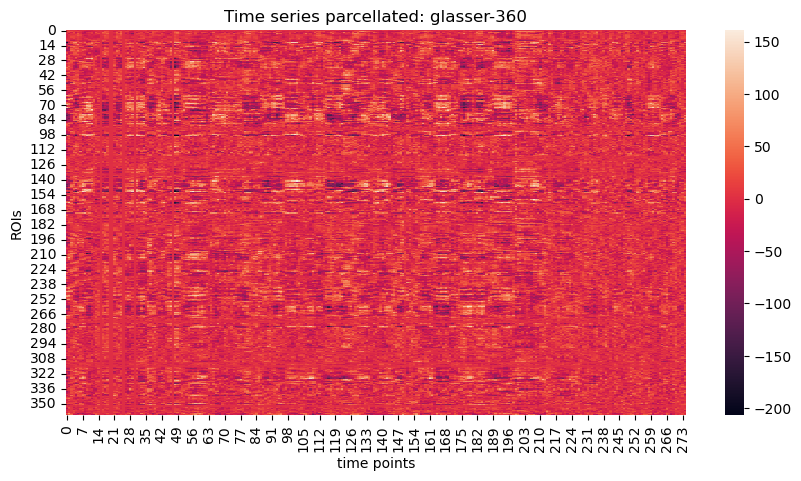

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the parcellated timeseries
f, ax = plt.subplots(figsize=(10,5))
g = sns.heatmap(timeseries_parc.T, ax=ax, cmap='rocket', xticklabels='auto', yticklabels='auto')
g.set_xlabel('time points')
g.set_ylabel('ROIs')
g.set_title(f'Time series parcellated: {parc_str}')


# Mean time series on surface

In [8]:
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_conte69

# Load the fsLR-32k surfaces
surf_lh, surf_rh = load_conte69()

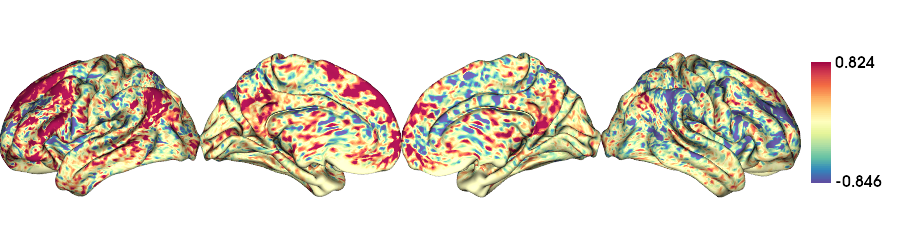

In [9]:
# Calculate the mean time series over time axis
ts_mean_fsLR32k = np.mean(timeseries, axis=0)

# OPtimize the color range for ploting
Range=(np.quantile(ts_mean_fsLR32k, 0.05), np.quantile(ts_mean_fsLR32k, 0.95))

# Plot of the mean of the original fsLR-32k timeseries on the surface
plot_hemispheres(surf_lh, surf_rh, array_name=ts_mean_fsLR32k, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 250), embed_nb=True, color_range=Range,
  color_bar='right')

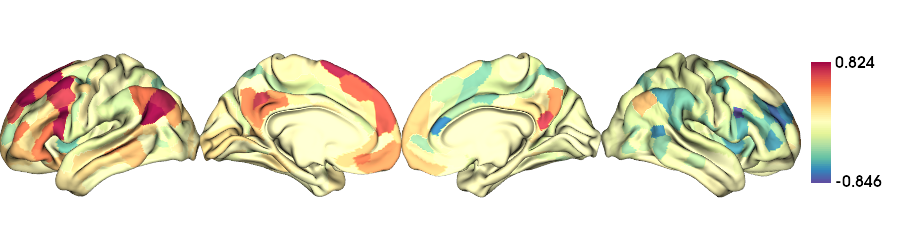

In [10]:
# Calculate the mean time series over time axis
ts_mean_parc = np.mean(timeseries_parc, axis=0)

# Map back to surface fsLR-32k
ts_mean_parc_32k = map_to_labels(ts_mean_parc, parc)

# Plot of the mean of the parcellated timeseries on the surface
plot_hemispheres(surf_lh, surf_rh, array_name=ts_mean_parc_32k, cmap='Spectral_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 250), embed_nb=True, color_range=Range,
  color_bar='right')

## BrainSpace: `reduce_by_labels`

The build-in function `reduce_by_labels` from *BrainSpace* will create the same output as the previous procedure.

> brainspace.utils.parcellation.reduce_by_labels(values, labels, weights=None, target_labels=None, red_op='mean', axis=0, dtype=None)

In [11]:
from brainspace.utils.parcellation import reduce_by_labels

# Parcelate cortical timeseries with BrainSpace
timeseries_parc_bs = reduce_by_labels(timeseries, parc)

In [12]:
# Test that both methos are equivalent
np.average(timeseries_parc == timeseries_parc_bs)

1.0